In [1]:
from __future__ import print_function
import os
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from custom_model.custom_layers import *
from custom_model.losses import *
import numpy as np
import keras
from keras.optimizers import Adam
from keras.utils import to_categorical
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [3]:
X, Xt, Y, Yt, mean_v, std_v = data_generator(15, 10, mode='multistep')
# Y = np.expand_dims(Y*0.95, axis=3)
# Yt = np.expand_dims(Yt*0.95, axis=3)
Y = np.expand_dims(Y*59, axis=3).astype(int)
Yt = np.expand_dims(Yt*59, axis=3).astype(int)
Y = to_categorical(Y)[:,7]
Yt = to_categorical(Yt)[:,7]
print(Y.shape, np.amin(Y), np.amax(Y))
print(Yt.shape, np.amin(Yt), np.amax(Yt))

(3295, 15, 201, 2) (3295, 10, 201)
(6474, 15, 201, 2) (6474, 10, 201)
(7815, 201, 60) 0.0 1.0
(1954, 201, 60) 0.0 1.0


In [4]:
model = STAG_home(obs=15, pred=10, k=4, time_length=5, nb_units=64, nb_blocks=8, mode='dgc')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model = STAG(obs=15, pred=10, k=4, time_length=5, nb_units=64, nb_blocks=10, mode='dgc')

In [ ]:
def scheduler(epoch):
   if epoch < 10:
     return 0.001
   else:
     return 0.0001
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model.compile(loss = nll_test(),
              optimizer=Adam())

history = model.fit(X,Y,
          epochs=64,
          batch_size=16, callbacks=[callback], verbose=1)

In [ ]:
model.compile(loss = focal_loss(),
              optimizer=Adam())

history = model.fit(X,Y,
          epochs=64,
          batch_size=32, callbacks=[callback], verbose=1)

In [ ]:
y = model.predict(Xt)
w,k = np.split(y,2,axis=-1)
w = w*0.98+0.01

k = 1/(k**2+1e-4)+0.2
a = w*k+1
b = (1-w)*k+1

mu = a/(a+b)
var = a*b/(a+b)**2/(a+b+1)

print(np.mean((mu-Yt)**2)**0.5*130, np.mean(var)*130*130,  np.mean(var)**0.5*130)

In [ ]:
Vin = z_inverse(Xt[...,0], mean_v, std_v)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(4,3))
ind_list = [indm[-r] for r in [9,31]]
for j in range(len(axes.flat)):
    ax = axes.flat[j]
    im = ax.set_axis_off()
    #im = ax.imshow(Yt[indm[-i*80-1]:indm[-i*80-1]+30,2,...,0].transpose()*130,interpolation='nearest', aspect='auto')
    im = ax.imshow(Vin[ind_list[j]].transpose()*130,interpolation='nearest', aspect='auto',vmin=0, vmax=130.)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, label='speed(km/h)',cax=cbar_ax)
fig.savefig('imgs/epis2.png', dpi=800,bbox_inches = "tight")
plt.show()

In [ ]:
file = h5py.File('pretrained/home8.h5','w')
weight = model.get_weights()
for i in range(len(weight)):
    file.create_dataset('weight'+str(i),data=weight[i])
file.close()

In [5]:
file=h5py.File('pretrained/home8.h5','r')
weight = []
for i in range(len(file.keys())):
    weight.append(file['weight'+str(i)][:])
model.set_weights(weight)

In [ ]:
for i in range(10):
    model = STAG(obs=15, pred=10, k=4, time_length=5, nb_units=64, nb_blocks=10, mode='dgc')
    model.compile(loss = nll_test(),
              optimizer=Adam())

    history = model.fit(X[:1954],Y[:1954],
                        epochs=32,
                        batch_size=16, callbacks=[callback])
    file = h5py.File('pretrained/model025'+str(i)+'.h5','w')
    weight = model.get_weights()
    for j in range(len(weight)):
        file.create_dataset('weight'+str(j),data=weight[j])
    file.close()
    K.clear_session()
    print(i, 'finished')

In [ ]:
model = STAG(obs=15, pred=10, k=4, time_length=5, nb_units=64, nb_blocks=10, mode='dgc')
model.compile(loss = nll_test(),
              optimizer=Adam())

size = 10
at = np.zeros((size, 1954, 10, 201))
bt = np.zeros((size, 1954, 10, 201))
#mut = np.zeros((size, 1954, 10, 201))
#vart = np.zeros((size, 1954, 10, 201))

for i in range(size):
    file=h5py.File('pretrained/model'+str(i)+'.h5','r')
    weight = []
    for j in range(len(file.keys())):
        weight.append(file['weight'+str(j)][:])
    model.set_weights(weight)
    
    #print(model.evaluate(Xt, Yt))
    y = model.predict(Xt)
    w,k = np.split(y,2,axis=-1)
    w = w*0.98+0.01

    k = 1/(k**2+1e-4)+0.2
    a = w*k+1
    b = (1-w)*k+1

    #mu = a/(a+b)
    #var = a*b/(a+b)**2/(a+b+1)
    at[i] = a[...,0]
    bt[i] = b[...,0]
    #mut[i] = mu[...,0]
    #vart[i] = var[...,0]
    
#pred = np.mean(mut, axis=0)
#aleatoric = np.mean(vart, axis=0)
#epistemic = np.var(mut, axis=0)
K.clear_session()
mu_ = np.mean(at/(at+bt), axis=0)
var_ = np.mean(at*bt/(at+bt)**2/(at+bt+1), axis=0)
a_ = mu_*(mu_*(1-mu_)/var_-1)
b_ = (1-mu_)*(mu_*(1-mu_)/var_-1)

In [ ]:
np.mean((pred-Yt.squeeze())**2)**0.5*130, np.mean(np.abs(pred-Yt.squeeze())/Yt.squeeze())*100, np.mean(np.abs(pred-Yt.squeeze()))*130

In [ ]:
pred = mu_
rmse = np.mean((pred-Yt.squeeze())**2, axis=(0,2))**0.5*130
mape = np.mean(np.abs(pred-Yt.squeeze())/Yt.squeeze(), axis=(0,2))*100
mae = np.mean(np.abs(pred-Yt.squeeze()), axis=(0,2))*130
for i in range(10):
    print(rmse[i])

In [ ]:
epistemic = np.var(mu, axis=0)
aleatoric = np.mean(var, axis=0)

In [ ]:
from scipy.stats import beta
from scipy.stats import moment
mu, var = beta.stats(at, bt, scale=130, moments='mv')

In [ ]:
from scipy.stats import beta, norm

p=9
percent = np.percentile(epistemic[:,p], np.array([2*i for i in range(51)]))
nb=[]
cali2=np.zeros(51)
for i in range(1,51):
    shred = percent[i]
    mask = epistemic[:,p]<shred
    n = mask.sum()
    nb.append(n)
    y_t = Yt.squeeze()[:,p]*mask
    y_p = mu_[:,p]*mask
    error = np.mean((y_p-y_t)**2)**0.5
    cali2[i] = error*130
    
    print(i, shred, n, cali2[i],end='\r')

In [ ]:
from scipy.stats import beta, norm
cali2=np.zeros(51)
step=9
mask = var_[:,step]<(5/130)**2
N = mask.sum()
print(N)

for i in range(51):
    print(i, end='\r')
    distri = beta.ppf(i/50, (a_[:,step]*mask).flatten(), (b_[:,step]*mask).flatten())
    count = ((Yt[:,step].squeeze()*mask).flatten())<distri
    cali2[i] = np.count_nonzero(count)/N

In [ ]:
def smoother(x_i,y,k=20):
    x = np.copy(x_i)
    vmax = np.amax(x)
    vmin = np.amin(x)
    ref = np.arange(vmin, vmax+(vmax-vmin)/k, (vmax-vmin)/k)
    avr = np.zeros(k)
    for i in range(k):
        avr[i] = np.mean(y[np.where(x<ref[i+1])])
        x[x<ref[i+1]] = 130
    return ref[:k]+(vmax-vmin)/k/2, avr

In [ ]:
um = np.mean(epistemic[:,:3],axis=(1,2))
indm = np.argsort(um)

In [ ]:
from scipy.stats import beta, norm

p=4
epis = np.transpose(epistemic,(2,0,1))/np.amax(epistemic, axis=-1)
epis = np.transpose(epis, (1,2,0))
#percent = np.array([i for i in np.arange(1, 51, 1)])
percent = np.percentile(epis[:,p], np.array([i for i in range(101)]))
nb=[]
cali2=np.zeros(len(percent))
cali=np.zeros(len(percent))
cali1=np.zeros(len(percent))
for i in range(1,len(percent)):
    if i==1:
        mask = epis[:,p]<percent[i]
    else:
        mask1 = epis[:,p]<=percent[i]
        mask2 = epis[:,p]>percent[i-1]
        mask = np.logical_and(mask1, mask2)
    n = mask.sum()
    nb.append(n)
    y_t = Yt.squeeze()[:,p]*mask
    y_p = mu_[:,p]*mask
    error = np.mean((y_p-y_t)**2)**0.5
    cali1[i] = error*130
    cali2[i] = np.mean(aleatoric[:,p]*mask)**0.5
    cali[i] = np.mean(epistemic[:,p]*mask)**0.5
    
    print(i, cali2[i],end='\r')

In [ ]:
#plt.plot(percent, cali2**2)
plt.plot(np.abs(cali1**2-cali2**2)**2)
#plt.plot(percent, cali**2)
plt.show()

In [ ]:
#um[um==np.nan]=0
plt.hist(um**0.5,bins=50, label= 'epistemic')
#plt.hist(ud**0.5,bins=30,alpha=0.5,label='aleatoric')
plt.ylabel('frequency', fontsize=15)
plt.xlabel('epis. $\sigma$ (km/h)', fontsize=15)
#plt.legend(fontsize=15)
plt.xlim(0,12)
#plt.yscale('symlog')
plt.savefig('imgs/episdistri.png', dpi=800)
plt.show()

In [ ]:
ent = out.eval(session=tf.compat.v1.Session())

In [ ]:
from scipy.stats import beta, norm

p=4
percent = np.percentile(epistemic[:,p], np.array([i for i in range(101)]))
nb=[]
cali2=np.zeros(101)
for i in range(1,101):
    if i==1:
        mask = epistemic[:,p]<percent[i]
    else:
        mask1 = epistemic[:,p]<=percent[i]
        mask2 = epistemic[:,p]>percent[i-1]
        mask = np.logical_and(mask1, mask2)
    n = mask.sum()
    nb.append(n)
    #y_t = Yt.squeeze()[:,p]*mask
    #y_p = mu_[:,p]*mask
    #error = np.mean((y_p-y_t)**2)**0.5
    #cali2[i] = error*130
    cali2[i] = np.nanmean(aleatoric[:,p]*mask)**0.5
    
    print(i, cali2[i],end='\r')

In [ ]:
for i in range(len(cali2)):
    print(percent[i]**0.5)
    #print(0.01*i)

In [6]:
X, Xts, Y, Yts, mean_v, std_v = data_generator(15, 10, mode='multistep')

Ys = model.predict(Xt)

(3295, 15, 201, 2) (3295, 10, 201)
(6474, 15, 201, 2) (6474, 10, 201)



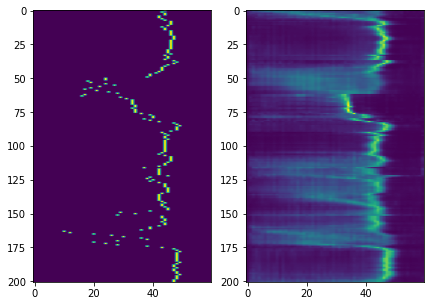

In [8]:
fig, axes = plt.subplots(1,2, figsize=(7,5))
ax1, ax2 = axes
ax1.imshow(Yt[350],aspect='auto')
ax1.
ax2.imshow(Ys[350],aspect='auto')
plt.show()

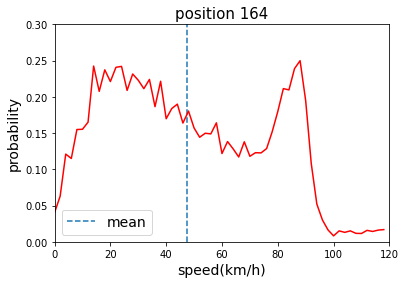

In [142]:
pos=164
plt.axvline(x = np.sum(Ys[820,pos]*np.arange(0,120,2))/np.sum(Ys[820,pos]), label='mean', ls='--',lw=1.5)
plt.plot(np.arange(0,120,2),Ys[820,pos], 'red')
plt.xlabel('speed(km/h)', fontsize=14)
plt.ylabel('probability', fontsize=14)
plt.xlim(0,120)
plt.ylim(0,0.3)
plt.legend(loc="lower left",fontsize='14')
plt.title('position 164',fontsize=15)
plt.savefig('imgs/pos164.png', dpi=800)
plt.show()

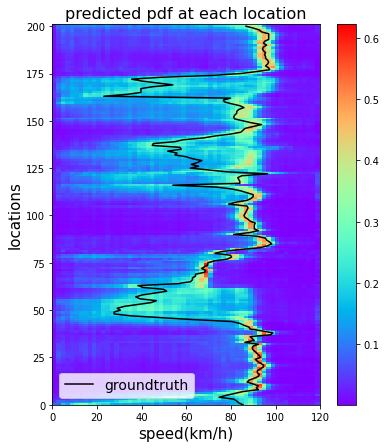

In [144]:
fig, ax = plt.subplots(figsize=(6,7))
x = np.arange(0,122,2)
y = np.arange(0,202)
im = ax.pcolormesh(x, y, Ys[820], cmap='rainbow')
#ax.imshow(Ys[350],aspect='auto',cmap='rainbow')
ax.plot(Yts[820,7]*120,np.arange(0,201),'black', lw=1.5, label='groundtruth')
ax.set_title('predicted pdf at each location',fontsize='16')
ax.set_xlabel('speed(km/h)',fontsize='15')
ax.set_ylabel('locations',fontsize='15')
ax.tick_params(axis='both', which='minor', labelsize=15)
plt.legend(loc="lower left",fontsize='14')
fig.colorbar(im,orientation='vertical')
plt.savefig('imgs/home.png', dpi=800)
plt.show()

In [ ]:
model.summary()

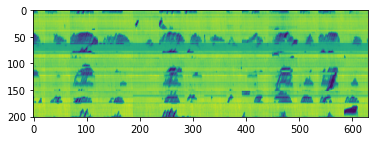

In [111]:
plt.imshow(Yts[300:930,7].transpose())

In [9]:
np.save("true_dis.npy", Ys[820, 164])

In [10]:
loaded_array = np.load("true_dis.npy")
loaded_array

array([0.04023084, 0.06299907, 0.12098923, 0.11494777, 0.15491131,
       0.15524134, 0.16504285, 0.2424705 , 0.20757037, 0.23724708,
       0.221113  , 0.24075219, 0.24201041, 0.20890024, 0.23150519,
       0.22287008, 0.21129847, 0.2239972 , 0.1864292 , 0.22148263,
       0.16977435, 0.1838162 , 0.18991879, 0.16381273, 0.18036482,
       0.15702677, 0.14425033, 0.14978033, 0.14887246, 0.16410244,
       0.12176651, 0.13830349, 0.12823948, 0.11702836, 0.137997  ,
       0.11797419, 0.12292451, 0.12264246, 0.12860462, 0.15189707,
       0.17967084, 0.21135753, 0.20958099, 0.23893559, 0.2498594 ,
       0.19474044, 0.10800302, 0.05204374, 0.03017792, 0.01641464,
       0.00818706, 0.01508465, 0.01300943, 0.01509416, 0.0116697 ,
       0.01149482, 0.01579523, 0.01427108, 0.01613793, 0.01683965],
      dtype=float32)